In [2]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

# Define the Stan model
stan_model_code = """
data {
    int<lower=0> N;
    vector[N] y;
}
parameters {
    real mu;
}
model {
    y ~ normal(mu, 1.0);
}
"""

# Write the Stan model to a file
with open('model.stan', 'w') as f:
    f.write(stan_model_code)


In [3]:
# Compile the Stan model
stan_model = CmdStanModel(stan_file='model.stan')

12:59:37 - cmdstanpy - INFO - compiling stan file E:\git\KOS6313\model.stan to exe file E:\git\KOS6313\model.exe
12:59:57 - cmdstanpy - INFO - compiled model executable: E:\git\KOS6313\model.exe


In [4]:
# Generate some synthetic data
np.random.seed(1)
N = 100
y = np.random.normal(0, 1, N)

y = np.array([-2., -1., 0., 1., 2.])
N = len(y)
# Prepare data for Stan
data = {'N': N, 'y': y}

# Find the MAP estimate using CmdStanPy's optimize method
map_estimate = stan_model.optimize(data=data)

print("MAP estimate of mu:", map_estimate.stan_variable('mu'))

13:00:13 - cmdstanpy - INFO - Chain [1] start processing
13:00:13 - cmdstanpy - INFO - Chain [1] done processing
13:00:13 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


MAP estimate of mu: -5.55112e-17


MAP estimate of mu: -0.04040404040404022


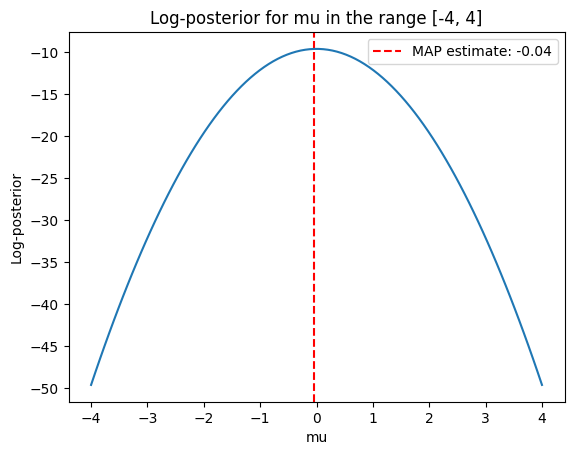

In [8]:
# Define the log-posterior function
def log_posterior(mu, y):
    sigma = 1.0
    N = len(y)
    return -0.5 * N * np.log(2 * np.pi * sigma**2) - np.sum((y - mu)**2) / (2 * sigma**2)

# Plot the log-posterior for mu in the range [-4, 4]
mu_values = np.linspace(-4, 4, 100)
log_posterior_values = [log_posterior(mu, y) for mu in mu_values]

lp_max = np.max(log_posterior_values), 
lp_max_index = np.argmax(log_posterior_values)
lp_map = mu_values[lp_max_index]
print("MAP estimate of mu:", lp_map)

plt.figure()
plt.axvline(x=lp_map, color='r', linestyle='--', label=f'MAP estimate: {lp_map:.2f}')
plt.legend()
plt.plot(mu_values, log_posterior_values)
plt.xlabel('mu')
plt.ylabel('Log-posterior')
plt.title('Log-posterior for mu in the range [-4, 4]')
plt.show()

In [10]:
# Sample from the posterior distribution
posterior_samples = stan_model.sample(data=data, iter_sampling=1000, iter_warmup=500, chains=4)

# Extract the samples for mu
mu_samples = posterior_samples.stan_variable('mu')

print("Posterior samples of mu:", mu_samples)
print("mean of the posterior samples:", np.mean(mu_samples))

13:04:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▌         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


13:04:46 - cmdstanpy - INFO - CmdStan done processing.



Posterior samples of mu: [ 0.529131  0.769024 -0.803681 ... -0.104768 -0.366837 -0.75115 ]
mean of the posterior samples: 0.009565722751750001


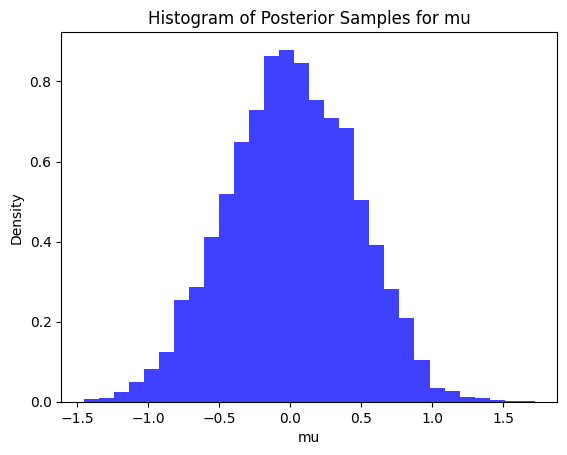

In [12]:
plt.figure()
plt.hist(mu_samples, bins=30, density=True, alpha=0.75, color='blue')
plt.xlabel('mu')
plt.ylabel('Density')
plt.title('Histogram of Posterior Samples for mu')
plt.show()

In [14]:
num_samples = posterior_samples.num_draws_sampling
print("Number of samples in posterior_samples:", num_samples)

Number of samples in posterior_samples: 1000


In [16]:
posterior_samples_summary = posterior_samples.summary()
print(posterior_samples_summary)

          Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__ -5.499610  0.016461  0.674349  0.332369 -6.810280 -5.244360 -5.001960   
mu    0.009566  0.010961  0.446993  0.463197 -0.735987  0.009905  0.736846   

      ESS_bulk  ESS_tail    R_hat  
lp__   1829.30   2260.82  1.00243  
mu     1672.67   1987.72  1.00252  


In [21]:
type(posterior_samples)

cmdstanpy.stanfit.mcmc.CmdStanMCMC

In [23]:
print(posterior_samples.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [24]:
?posterior_samples

Type:           CmdStanMCMC
String form:   
CmdStanMCMC: model=model chains=4['method=sample', 'num_samples=1000', 'num_warmup=500', 'algorit <...> .txt
           C:\Users\VIP\AppData\Local\Temp\tmppmxw8ixi\modelbkha049t\model-20250303130446_3-stdout.txt
File:           e:\git\kos6313\.venv\lib\site-packages\cmdstanpy\stanfit\mcmc.py
Docstring:     
Container for outputs from CmdStan sampler run.
Provides methods to summarize and diagnose the model fit
and accessor methods to access the entire sample or
individual items. Created by :meth:`CmdStanModel.sample`

The sample is lazily instantiated on first access of either
the resulting sample or the HMC tuning parameters, i.e., the
step size and metric.
Init docstring: Initialize object.

In [26]:
ps = posterior_samples
ps.draws().shape, ps.draws_pd().shape

((1000, 4, 8), (4000, 11))

In [27]:
ps.draws_pd().head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu
0,1.0,1.0,1.0,-5.69995,0.980177,0.968673,3.0,7.0,0.0,6.70389,0.529131
1,1.0,2.0,2.0,-6.47849,0.865522,0.968673,1.0,1.0,0.0,6.48544,0.769024
2,1.0,3.0,3.0,-6.61476,0.995214,0.968673,2.0,7.0,0.0,6.64210,-0.803681
3,1.0,4.0,4.0,-5.01635,0.925393,0.968673,2.0,3.0,0.0,7.47677,0.080880
4,1.0,5.0,5.0,-5.64644,0.781448,0.968673,2.0,3.0,0.0,7.02404,-0.508505


In [28]:
ps.draws(concat_chains=True).shape

(4000, 8)

In [33]:
s = ps.draws(concat_chains=True)
s.shape

(4000, 8)

In [42]:
ps.draws_pd().columns

Index(['chain__', 'iter__', 'draw__', 'lp__', 'accept_stat__', 'stepsize__',
       'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'mu'],
      dtype='object')

In [43]:
ps.draws_pd().keys()

Index(['chain__', 'iter__', 'draw__', 'lp__', 'accept_stat__', 'stepsize__',
       'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'mu'],
      dtype='object')

In [41]:
s[:,-1] # last column is mu; the order is the same as the order of keywords in ps.draws_pd().columns

array([ 0.529131,  0.769024, -0.803681, ..., -0.104768, -0.366837,
       -0.75115 ], shape=(4000,))

Text(0.5, 0, 'mu')

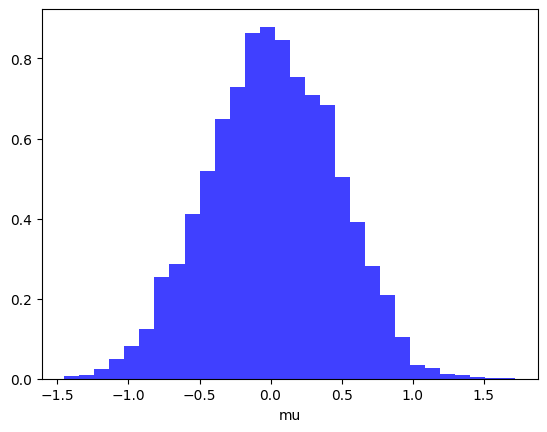

In [38]:
plt.hist(s[:,-1], bins=30, density=True, alpha=0.75, color='blue')
plt.xlabel('mu')

Text(0.5, 0, 'mu')

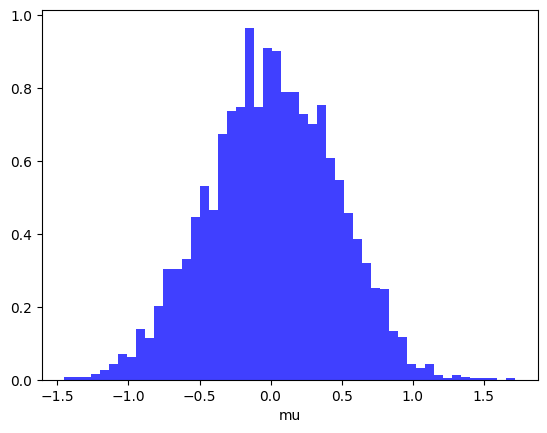

In [44]:
plt.hist(ps.draws_pd()['mu'], bins=50, density=True, alpha=0.75, color='blue')
plt.xlabel('mu')

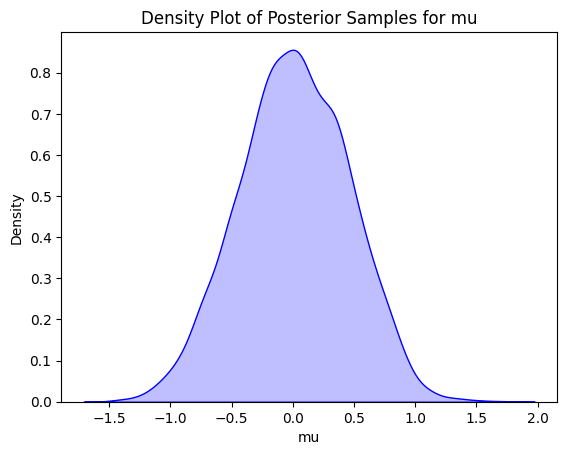

In [48]:
import seaborn as sns

plt.figure()
sns.kdeplot(mu_samples, fill=True, color='blue')
plt.xlabel('mu')
plt.ylabel('Density')
plt.title('Density Plot of Posterior Samples for mu')
plt.show()